In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import xarray as xr

import matplotlib.pyplot as plt
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar

from bs_fdbck.util.imports import import_fields_xr_echam

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud,rn_dic_noresm_cloud

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

import pandas as pd

/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/bs_fdbck/data_info/area_defs.csv


In [4]:
from timeit import default_timer as timer



from dask.diagnostics import ProgressBar

from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [5]:

select_station = 'ATTO'

In [6]:
xr.set_options(keep_attrs=True) 

In [7]:
calc_seasons = ['ALL_year']

In [8]:
tau_lims = [5,50]
r_eff_lim = 1
cloud_top_temp_above = -15 
cld_water_path_above = 50
#include_months = [7,8]

In [9]:
from bs_fdbck.constants import path_measurement_data
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'



In [10]:
lon_lims = [293.,308.]
lat_lims = [-8.,-1.]

lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-2


temperature = 273.15  # K


from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'
sel_years_from_files = ['2012','2014','2015','2018']

## Daytime values


Set the daytime to be from 10 to 17 each day

In [11]:
daytime_from = 9
daytime_to = daytime_from + 7

## Read in model station data:

In [12]:
models = ['ECHAM-SALSA','NorESM','EC-Earth']
mod2cases = {'ECHAM-SALSA':['SALSA_BSOA_feedback'],
             'NorESM':['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth':['ECE3_output_Sara'],
            }
di_mod2cases = mod2cases.copy()

In [13]:
dic_df_station=dict()
for mod in models:
    print(mod)
    dic_df_station[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_station[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_station[mod][ca].index = pd.to_datetime(dic_df_station[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_EC-Earth_ECE3_output_Sara.csv


<AxesSubplot:xlabel='time'>

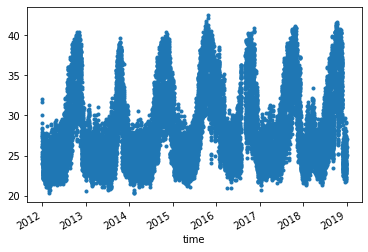

In [14]:
dic_df_station[mod][ca]['T_C'].plot(marker='.')

## EC-Earth

### Names etc

In [15]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

### Input path:

In [16]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth / case_name_ec_earth

In [17]:

cases_ec_earth = [case_name_ec_earth]

### Station variables  and others

### Define some strings for files

In [18]:

str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

### Filenames: 

In [19]:
fn_intermediate_ec_earth = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate.nc'
fn_intermediate_ec_earth_lev = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate_lev.nc'

fn_final_ec_earth = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'
fn_final_ec_earth_csv_stem = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}'

In [20]:
fn_final_ec_earth_csv_stem

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0')

### Open data

In [21]:
which='IFS'

In [22]:
fn_t = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'


In [23]:
fn_t.exists()

True

In [24]:
fl_open = []
#ds_list =[]
dic_ds =dict()

for which in ['IFS','IFS_T']:
    fn = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
    print(fn)
    if fn.exists():
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        dic_ds[which] = _ds
    else:
        print(f'{v} not found')
        

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc


/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_T_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc


### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [25]:
dic_df_station[model_name_ec_earth][case_name_ec_earth].head()

,station,time_orig,lev,CCN0.20,CCN1.00,M_BCACS,M_BCAII,M_BCAIS,M_BCCOS,M_DUACI,...,N150-500,N200-500,OA,POM,SOA,SOA2,T_C,is_JJA,is_JA,isSummer
time,,,,,,,,,,,,,,,,,,,,,
2011-12-31 20:00:00,ATTO,2012-01-01 00:30:00.000000000,2.0,104.46652,169.93945,7.749801e-11,1.195486e-11,5.233935e-13,1.018316e-14,4.597259e-10,...,100.961462,71.034853,1.762270,0.664647,1.097623,1.097623,NaN,False,False,False
2011-12-31 21:00:00,ATTO,2012-01-01 01:30:00.000000000,2.0,104.66638,170.33379,7.789928e-11,1.206712e-11,5.107936e-13,1.031701e-14,4.591339e-10,...,101.024142,71.109470,1.764701,0.667787,1.096914,1.096914,NaN,False,False,False
2011-12-31 22:00:00,ATTO,2012-01-01 02:30:00.000000000,2.0,104.61212,170.43909,7.815295e-11,1.211496e-11,5.031363e-13,1.039341e-14,4.575842e-10,...,100.819331,70.990696,1.759449,0.669758,1.089691,1.089691,NaN,False,False,False
2011-12-31 23:00:00,ATTO,2012-01-01 03:30:00.000000000,2.0,104.51892,170.58879,7.841911e-11,1.214463e-11,4.996820e-13,1.044115e-14,4.560449e-10,...,100.559394,70.822420,1.750940,0.671862,1.079078,1.079078,27.902313,False,False,False
2012-01-01 00:00:00,ATTO,2012-01-01 04:30:00.000000000,2.0,104.40431,170.79070,7.870423e-11,1.216151e-11,4.994802e-13,1.048248e-14,4.545686e-10,...,100.263232,70.621023,1.739966,0.674125,1.065841,1.065841,NaN,False,False,False


In [26]:
from bs_fdbck.util.BSOA_datamanip.ec_earth import (
    rename_ifs_vars,
    fix_units_ec_earth,
    extract_cloud_top,
    calculate_incld_values_warmclouds,
    make_dummy_lev,
    
)

## Fix units, calc cloud properties etc.

In [34]:
if True:# not fn_intermediate_ec_earth.exists():
    

    for key in dic_ds:
        _ds = dic_ds[key]
        _ds=rename_ifs_vars(_ds)
        
        _ds = fix_units_ec_earth(_ds)
        #_ds = calculate_incld_values_warmclouds(_ds)
        #_ds = extract_cloud_top(_ds)
        #_ds['lat'] = np.round(_ds['lat'], decimals=2)
        #_ds['lon'] = np.round(_ds['lon'], decimals=2)
        _ds = _ds.sortby('lon')
        _ds = _ds.sortby('lat')
        _ds=(
            _ds
            .assign(
                lat=lambda d:d['lat'].astype('float').round(2))
            .assign(
                lon=lambda d:d['lon'].astype('float').round(2))
        )

        dic_ds[key] = _ds
    

    ds = dic_ds['IFS']
    

renaming var130 to temp
renaming var131 to U
renaming var132 to V
renaming var136 to tcw
renaming var137 to tcwv
renaming var164 to ttc
renaming var176 to surf_net_srad
renaming var177 to surf_net_lrad
renaming var178 to toa_net_srad
renaming var179 to toa_net_lrad
renaming var20 to cdnc
renaming var208 to toa_net_srad_clear
renaming var21 to re_liq
renaming var210 to surf_net_srad_clear
renaming var211 to sur_net_lrad_clear
renaming var22 to liq_cloud_time
renaming var248 to cc
renaming var68 to toa_net_srad_clearclean
renaming var69 to toa_net_srad_clean
renaming var70 to surf_net_srad_clearclean
renaming var71 to surf_net_srad_clean
renaming var72 to toa_net_lrad_clearclean
renaming var73 to toa_net_lrad_clean
renaming var74 to surf_net_lrad_clearclean
renaming var75 to surf_net_lrad_clean
renaming var78 to tclw
renaming var79 to tciw
Converting tcw from kg/m2 to g/m2
Converting tcwv from kg/m2 to g/m2
Converting tclw from kg/m2 to g/m2
Converting tciw from kg/m2 to g/m2
renaming va

In [35]:
    ds = calculate_incld_values_warmclouds(ds)
    

calculating re_liq_incld
calculating cdnc_incld
calculating cl_time_liq_norm
Calulating cc_all
Calulating liq_frac_cwp
calculating cl_frac_where_cltime_post
calculating cwp_incld


In [36]:
    ds = extract_cloud_top(ds)
    
    dic_ds['IFS'] = ds

In [173]:
_ds = ds.sel(time=slice('2012-06','2012-09'))

In [174]:
_ds.load()

<xarray.Dataset>
Dimensions:                   (lev: 91, nhyi: 92, nhym: 91, lat: 10, lon: 22, plev: 11, time: 975)
Coordinates:
    lev_orig                  (lev) float64 1.0 2.0 3.0 4.0 ... 89.0 90.0 91.0
  * lat                       (lat) float64 -7.37 -6.67 -5.96 ... -1.75 -1.05
  * lon                       (lon) float64 293.2 293.9 294.6 ... 307.3 308.0
  * plev                      (plev) float64 1e+05 9.25e+04 ... 5e+03 1e+03
  * time                      (time) datetime64[ns] 2012-06-01 ... 2012-09-30...
  * lev                       (lev) float64 0.01 0.0299 0.05684 ... 996.0 998.8
Dimensions without coordinates: nhyi, nhym
Data variables: (12/43)
    hyai                      (nhyi) float64 0.0 2.0 3.981 ... 6.576 0.00316 0.0
    hyam                      (nhym) float64 1.0 2.99 5.684 ... 3.289 0.00158
    hybi                      (nhyi) float64 0.0 0.0 0.0 ... 0.9942 0.9976 1.0
    hybm                      (nhym) float64 0.0 0.0 0.0 ... 0.9959 0.9988
    temp                      (time, plev, lat, lon) float32 -5.817e-05 ... 0.0
    U                         (time, plev, lat, lon) float32 0.0 ... 3.986e-07
    ...                        ...
    cwp_incld                 (time, lat, lon) float32 21.65 2.18 ... 89.26
    cumsum                    (time, lev, lat, lon) float32 nan nan ... nan nan
    argmax                    (time, lat, lon) int64 -38 -38 -38 ... -23 -23 -23
    cdnc_incld_cltop          (time, lat, lon) float32 471.7 469.8 ... 272.7
    re_liq_incld_cltop        (time, lat, lon) float32 5.333 5.333 ... 9.503
    cc_cltop                  (time, lat, lon) float32 0.1328 0.125 ... 0.1406
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Dec 20 16:59:11 2022: ncrcat /proj/bolinc/users/x_sarbl...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [40]:
_ds.to_netcdf('test2.nc')

In [27]:
_ds = xr.open_dataset('test2.nc')
_ds.load()

<xarray.Dataset>
Dimensions:                   (lev: 91, nhyi: 92, nhym: 91, lat: 10, lon: 22, plev: 11, time: 1454)
Coordinates:
    lev_orig                  (lev) float64 1.0 2.0 3.0 4.0 ... 89.0 90.0 91.0
  * lat                       (lat) float64 -7.37 -6.67 -5.96 ... -1.75 -1.05
  * lon                       (lon) float64 293.2 293.9 294.6 ... 307.3 308.0
  * plev                      (plev) float64 1e+05 9.25e+04 ... 5e+03 1e+03
  * time                      (time) datetime64[ns] 2012-01-01T03:00:00 ... 2...
  * lev                       (lev) float64 0.01 0.0299 0.05684 ... 996.0 998.8
Dimensions without coordinates: nhyi, nhym
Data variables: (12/43)
    hyai                      (nhyi) float64 0.0 2.0 3.981 ... 6.576 0.00316 0.0
    hyam                      (nhym) float64 1.0 2.99 5.684 ... 3.289 0.00158
    hybi                      (nhyi) float64 0.0 0.0 0.0 ... 0.9942 0.9976 1.0
    hybm                      (nhym) float64 0.0 0.0 0.0 ... 0.9959 0.9988
    temp                      (time, plev, lat, lon) float32 9.918e-05 ... 0.0
    U                         (time, plev, lat, lon) float32 0.0 ... 1.163e-05
    ...                        ...
    cwp_incld                 (time, lat, lon) float32 6.515 53.57 ... 207.6
    cumsum                    (time, lev, lat, lon) float32 nan nan ... nan nan
    argmax                    (time, lat, lon) int64 -34 -34 -33 ... -33 -33 -33
    cdnc_incld_cltop          (time, lat, lon) float32 120.8 126.1 ... 64.57
    re_liq_incld_cltop        (time, lat, lon) float32 8.0 16.0 ... 16.0 8.0
    cc_cltop                  (time, lat, lon) float32 0.02344 ... 0.007812
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Dec 20 16:59:11 2022: ncrcat /proj/bolinc/users/x_sarbl...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [29]:
import numpy as np

In [30]:
bins = np.linspace(0,35)

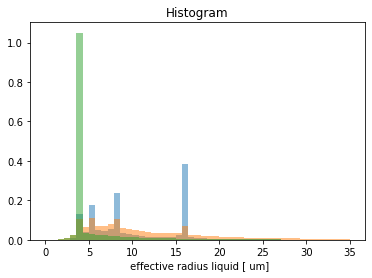

In [31]:
bins = np.linspace(0,35)
_ds['re_liq_incld_cltop'].plot(bins=bins, alpha=.5, density=True);

_ds['re_liq_incld'].plot(bins=bins, alpha=.5, density= True);
_ds['re_liq'].plot(bins=bins, alpha=.5, density= True);

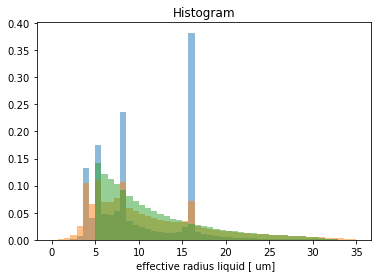

In [36]:
bins = np.linspace(0,35)
_ds['re_liq_incld_cltop'].plot(bins=bins, alpha=.5, density=True);

_ds['re_liq_incld'].plot(bins=bins, alpha=.5, density= True);
_ds['re_liq'].where(_ds['re_liq']>5).plot(bins=bins, alpha=.5, density= True);

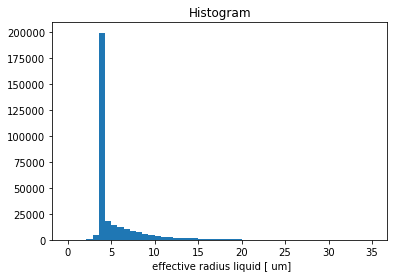

In [41]:
(
    _ds['re_liq']
    .where(_ds['cl_frac_where_cltime_pos']>0)
    .isel(lev=_ds['argmax'])
    .plot.hist(bins = np.linspace(0,35))
          
);
    

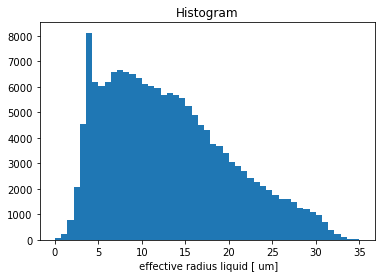

In [42]:
(
    _ds['re_liq']
    .where(_ds['cl_frac_where_cltime_pos']>0)
    .isel(lev=-22)
    .plot.hist(bins = np.linspace(0,35))
          
);
    

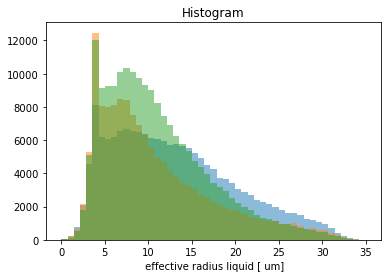

In [58]:
(
    _ds['re_liq']
    .where(_ds['cl_frac_where_cltime_pos']>0)
    .isel(lev=-22)
    .plot.hist(bins = np.linspace(0,35), alpha=0.5)
          
);

(
    _ds['re_liq']
    .where(_ds['cl_frac_where_cltime_pos']>0)
    .isel(lev=-12)
    .plot.hist(bins = np.linspace(0,35), alpha=0.5)
          
);
    
(
    _ds['re_liq']
    .where(_ds['cl_frac_where_cltime_pos']>0)
    .isel(lev=(_ds['argmax']+10))
    .plot.hist(bins = np.linspace(0,35), alpha=.5)
          
);

(array([ 43223., 120979.,  46830.,  50557.,  15120.,  15387.,   8849.,
          3933.,   1331.,  13671.]),
 array([-39. , -35.2, -31.4, -27.6, -23.8, -20. , -16.2, -12.4,  -8.6,
         -4.8,  -1. ]),
 <BarContainer object of 10 artists>)

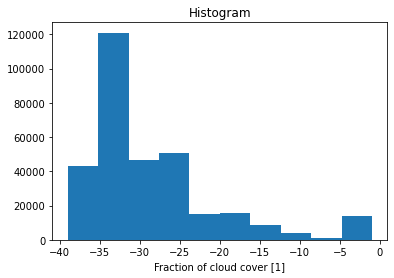

In [59]:
_ds['argmax'].plot()

(array([ 62177., 102025.,  31108.,  46495.,  19784.,  15120.,  12394.,
          7991.,   6280.,  16506.]),
 array([255.25551433, 329.61147045, 403.96742656, 478.32338267,
        552.67933878, 627.0352949 , 701.39125101, 775.74720712,
        850.10316324, 924.45911935, 998.81507546]),
 <BarContainer object of 10 artists>)

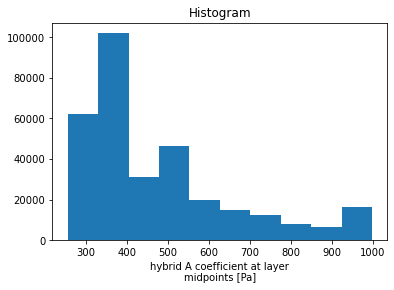

In [61]:
_ds['lev'].isel(lev=_ds['argmax']).plot()

In [ ]:
bins = np.linspace(0,35)
_ds['re_liq_incld_cltop'].plot(bins=bins, alpha=.5, density=True);

_ds['re_liq_incld'].plot(bins=bins, alpha=.5, density= True);
_ds['re_liq'].where(ds['re_liq']>5).plot(bins=bins, alpha=.5, density= True);

In [ ]:
_ds['re_liq_incld2'] = ((_ds['re_liq']*ds['liq_cloud_time'])
                              .where(_ds['liq_cloud_time'] > 0)
                              .where(_ds['re_liq'] > 0)
                              /_ds['liq_cloud_time']
                      )
                       # sec_in_timestep

In [34]:
sec_in_timestep = 60*60*3

In [35]:
sec_in_timestep

10800

In [177]:
_ds['re_liq_incld3'] = ((_ds['re_liq']*_ds['liq_cloud_time'])
                              .where(_ds['liq_cloud_time'] > 0)
                              .where(_ds['re_liq'] > 0)
                              /sec_in_timestep
                      )
                       # sec_in_timestep

In [178]:
_ds['re_liq_incld6'] = ((_ds['re_liq']*_ds['liq_cloud_time'])
                              .where(_ds['liq_cloud_time'] > 0)
                              .where(_ds['re_liq'] > 0)
                              /_ds['liq_cloud_time']
                      )
                       # sec_in_timestep

In [179]:
_ds['re_liq_incld4'] = ((_ds['re_liq']/_ds['liq_cloud_time'])
                              .where(_ds['liq_cloud_time'] > 0)
                              .where(_ds['re_liq'] > 0)
                              *sec_in_timestep
                      )
                       # sec_in_timestep

In [180]:
_ds['re_liq_incld5'] = ((_ds['re_liq'])
                              .where(_ds['liq_cloud_time'] > 0)
                              .where(_ds['re_liq'] > 0)
                      )
                       # sec_in_timestep

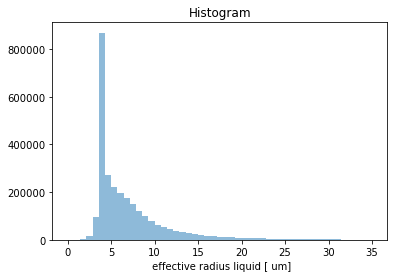

In [181]:
_ds['re_liq_incld5'].plot(bins=bins, alpha=0.5, label='3');
#_ds['re_liq_incld6'].plot(bins=bins, alpha=0.5, label='6');
#_ds['re_liq_incld5'].plot(bins=bins, alpha=0.5, label='5');


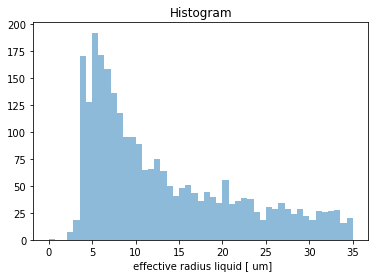

In [202]:
(
    (_ds['re_liq']
    /_ds['cl_frac_where_cltime_pos']
    /_ds['cl_time_liq_norm']
    )
    .where(_ds['cl_frac_where_cltime_pos']>0)
    .where(_ds['cl_time_liq_norm']>0)
    .isel(lev=88)
    .plot.hist(bins=bins, alpha=0.5, label='3')
);
#_ds['re_liq_incld6'].plot(bins=bins, alpha=0.5, label='6');
#_ds['re_liq_incld5'].plot(bins=bins, alpha=0.5, label='5');


In [272]:
sec_in_timestep

10800

In [281]:
bins = np.linspace(0,40)

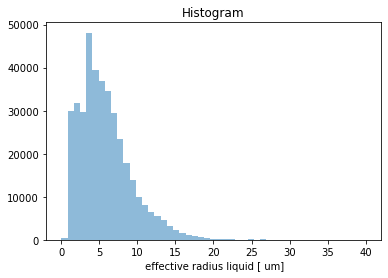

In [283]:
(
    (_ds['re_liq_cltop']
    *_ds['cl_time_liq_norm']
     #/_ds['cl_frac_where_cltime_pos']
    #/_ds['cl_time_liq_norm']
    # *sec_in_timestep/10000
    )
    #.where(_ds['cl_frac_where_cltime_pos']>0)
    #.where(_ds['cl_time_liq_norm']>0)
    #isel(lev=88)
    .plot.hist(bins=bins, alpha=0.5, label='3')
);
#_ds['re_liq_incld6'].plot(bins=bins, alpha=0.5, label='6');
#_ds['re_liq_incld5'].plot(bins=bins, alpha=0.5, label='5');


In [242]:
_ds['re_liq_cltop'] = _ds['re_liq'].where(_ds['cl_frac_where_cltime_pos']>.1).isel(lev=_ds['argmax'])
_ds['re_liq_cltop'] = _ds['re_liq_cltop'].where(_ds['argmax']<-2)
_ds['re_liq_cltop'] = _ds['re_liq_cltop'].where(_ds['argmax']>-30)

(3.8, 4.1)

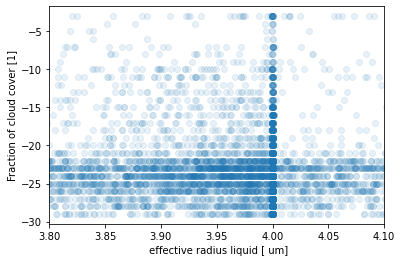

In [248]:
_ds.plot.scatter(x='re_liq_cltop', y='argmax', alpha=0.1)
plt.xlim([3.8,4.1])

(3.8, 4.1)

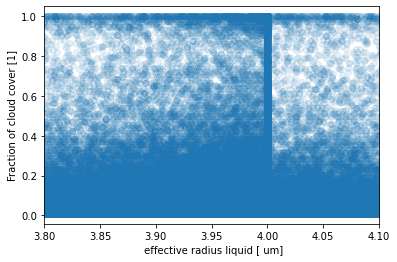

In [254]:
_ds.where(_ds['liq_cloud_time']>0).plot.scatter(x='re_liq', y='cl_frac_where_cltime_pos', alpha=0.01)
plt.xlim([3.8,4.1])

(3.8, 4.1)

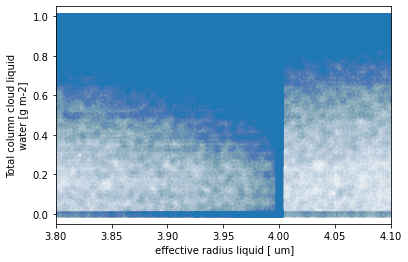

In [263]:
_ds.where(_ds['liq_cloud_time']>0).plot.scatter(x='re_liq', y='liq_frac_cwp', alpha=0.01)
plt.xlim([3.8,4.1])

(3.8, 4.1)

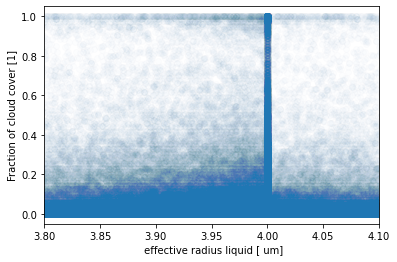

In [262]:
_ds.where(_ds['liq_cloud_time']>0).plot.scatter(x='re_liq', y='cc', alpha=0.01)
plt.xlim([3.8,4.1])

(3.8, 4.1)

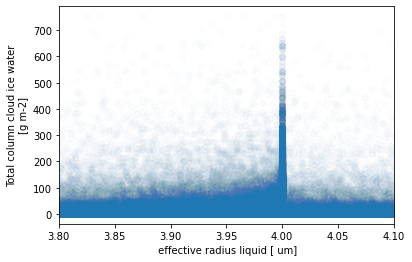

In [259]:
_ds.where(_ds['liq_cloud_time']>0).plot.scatter(x='re_liq', y='tciw', alpha=0.01)
plt.xlim([3.8,4.1])

In [ ]:
_ds['tot_cwp'] = _ds['tclw']+_ds['

(3.8, 4.1)

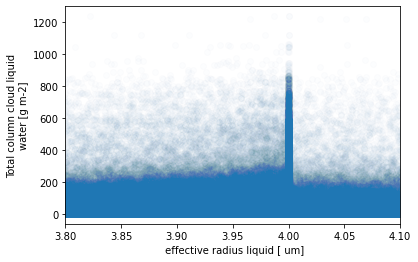

In [260]:
_ds.where(_ds['liq_cloud_time']>0).plot.scatter(x='re_liq', y='tclw', alpha=0.01)
plt.xlim([3.8,4.1])

(3.8, 4.1)

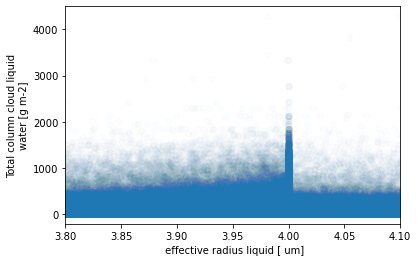

In [261]:
_ds.where(_ds['liq_cloud_time']>0).plot.scatter(x='re_liq', y='cwp_incld', alpha=0.01)
plt.xlim([3.8,4.1])

(3.8, 4.1)

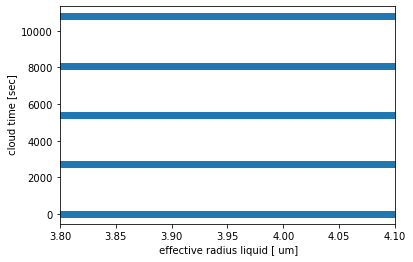

In [258]:
_ds.plot.scatter(x='re_liq', y='liq_cloud_time', alpha=0.007)
plt.xlim([3.8,4.1])

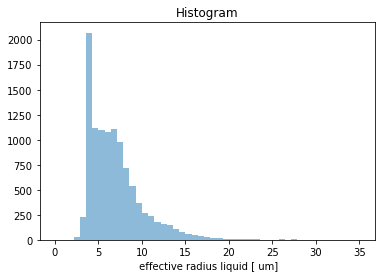

In [244]:
(
    _ds['re_liq_cltop']
    .where(_ds['cl_frac_where_cltime_pos']>.1)
    .where(_ds['liq_cloud_time']>1)
    .where(_ds['argmax']<-6)
    #.where(_ds['liq_frac_cwp']>0.9)
    #.where(_ds['cc']>0.9)
    .isel(lev=-22)
    .plot.hist(bins=bins, alpha=0.5, label='3')
);
#_ds['re_liq_incld6'].plot(bins=bins, alpha=0.5, label='6');
#_ds['re_liq_incld5'].plot(bins=bins, alpha=0.5, label='5');


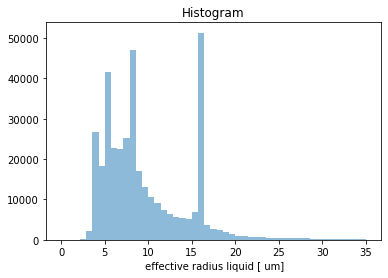

In [210]:
(
    _ds['re_liq_incld_cltop']
    .where(_ds['cl_frac_where_cltime_pos']>.1)
    .where(_ds['liq_cloud_time']>1)
    #.where(_ds['liq_frac_cwp']>0.9)
    #.where(_ds['cc']>0.9)
    #.isel(lev=88)
    .plot.hist(bins=bins, alpha=0.5, label='3')
);
#_ds['re_liq_incld6'].plot(bins=bins, alpha=0.5, label='6');
#_ds['re_liq_incld5'].plot(bins=bins, alpha=0.5, label='5');


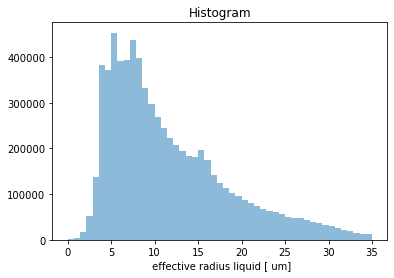

In [153]:
(
    (_ds['re_liq']
    /_ds['cl_time_liq_norm'])
    #.where(lambda d: (np.abs(d-4.)>.01))
    .where((np.abs(_ds['re_liq']-4.)>.02))
    .plot(bins=bins, alpha=0.5, label='3')
);

ax = plt.gca()
#ax.set_yscale('log')

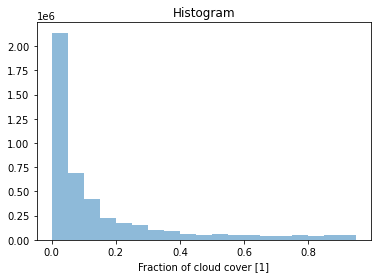

In [133]:
(
    #(_ds['re_liq_incld5']/_ds['cl_frac_where_cltime_pos'])
    (_ds['cl_frac_where_cltime_pos'])
    .plot(bins=np.arange(0,1,.05), alpha=0.5, label='3')
);


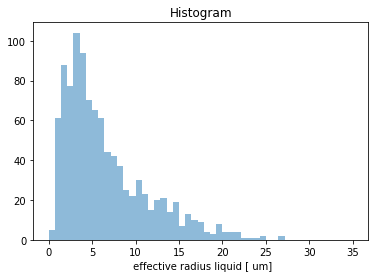

In [109]:
_ds['re_liq_incld3'].isel(lev=88, lat=0, lon=0).plot.hist(bins=bins, alpha=0.5, label='3');
#_ds['re_liq_incld6'].plot(bins=bins, alpha=0.5, label='6');
#_ds['re_liq_incld5'].plot(bins=bins, alpha=0.5, label='5');


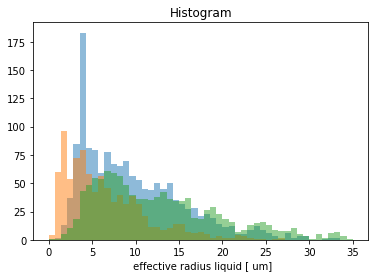

In [117]:
_ds['re_liq'].isel(lev=80, lat=0, lon=0).plot.hist(bins=bins, alpha=0.5, label='3');
_ds['re_liq_incld3'].isel(lev=90, lat=0, lon=0).plot.hist(bins=bins, alpha=0.5, label='3');
_ds['re_liq_incld4'].isel(lev=80, lat=0, lon=0).plot.hist(bins=bins, alpha=0.5, label='3');
#_ds['re_liq_incld6'].plot(bins=bins, alpha=0.5, label='6');
#_ds['re_liq_incld5'].plot(bins=bins, alpha=0.5, label='5');


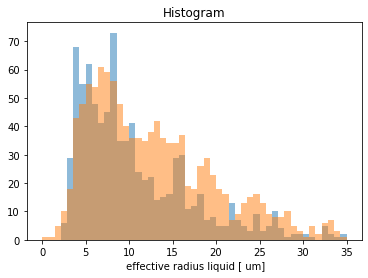

In [120]:
_ds['re_liq_incld4'].isel(lev=90, lat=0, lon=0).plot.hist(bins=bins, alpha=0.5, label='3');
_ds['re_liq_incld4'].isel(lev=80, lat=0, lon=0).plot.hist(bins=bins, alpha=0.5, label='3');


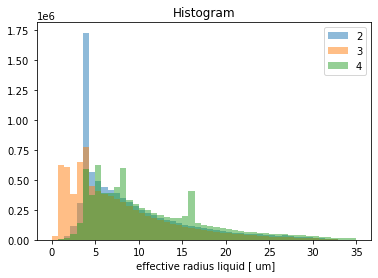

In [97]:
bins = np.linspace(0,35)

_ds['re_liq_incld2'].plot(bins=bins, alpha=0.5, label='2')
_ds['re_liq_incld3'].plot(bins=bins, alpha=0.5, label='3')
_ds['re_liq_incld4'].plot(bins=bins, alpha=0.5, label='4')
#ds['re_liq'].plot(bins=bins, alpha=.5, label='');
#ds['re_liq_incld'].plot(bins=bins, alpha=.5, label='orig');
plt.legend()

In [321]:
_ds['cl_time_liq_norm'] = _ds['liq_cloud_time']/sec_in_timestep

In [336]:
_ds['re_liqxcltime'] =_ds['re_liq']*sec_in_timestep
_ds['4_liqx(tott-cltime)'] = 4*(sec_in_timestep- _ds['liq_cloud_time'])*sec_in_timestep

_ds['re_liq_test'] = (_ds['re_liq'] - 4*(1-_ds['cl_time_liq_norm']))/_ds['cl_time_liq_norm']
#/_ds['cl_time_liq_norm']-4/(1-_ds['cl_time_liq_norm'])

In [390]:
_ds['re_liq_test_cltop'] = (_ds['re_liq_test']
                            .where(_ds['cl_frac_where_cltime_pos']>0)
                            .where(_ds['liq_frac_cwp']>.80)
                            .isel(lev=_ds['argmax'])
                           )

_ds['re_liq_cltop'] = (_ds['re_liq']
                            .where(_ds['cl_frac_where_cltime_pos']>0)
                            #.where(_ds['liq_frac_cwp']>.80)
                            .where(_ds['argmax']<-11)
                            .where(_ds['argmax']>-15)
                            .isel(lev=_ds['argmax'])
                           )

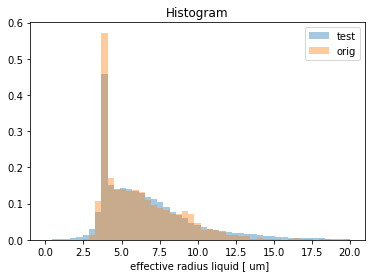

In [391]:
_ds['re_liq_test_cltop'].plot(bins=bins, alpha=0.4, label='test', density=True);
_ds['re_liq_cltop'].plot(bins=bins, alpha=0.4, label='orig', density=True);
plt.legend()

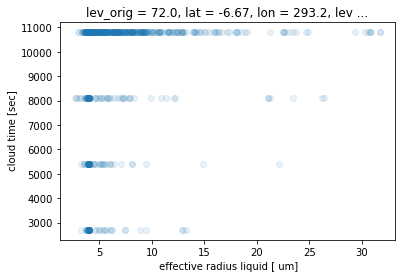

In [414]:
df = _ds[['re_liq', 'liq_cloud_time']].isel(lon=0, lat=1, lev=-20).to_dataframe()
_ds[['re_liq', 'liq_cloud_time']].where(_ds['liq_cloud_time']>0).isel(lon=0, lat=1, lev=-20).plot.scatter(x='re_liq',y='liq_cloud_time', alpha=0.1)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01166667, 0.0875    , 0.55416667,
        0.18666667, 0.16916667, 0.11666667, 0.1225    , 0.06416667,
        0.11083333, 0.14      , 0.06416667, 0.08166667, 0.0875    ,
        0.05833333, 0.05833333, 0.09333333, 0.035     , 0.035     ,
        0.02333333, 0.04083333, 0.00583333, 0.04083333, 0.02916667,
        0.02333333, 0.035     , 0.01166667, 0.        , 0.035     ,
        0.01166667, 0.0175    , 0.00583333, 0.00583333, 0.02333333,
        0.01166667, 0.        , 0.01166667, 0.00583333, 0.0175    ,
        0.00583333, 0.01166667, 0.        , 0.        ]),
 array([ 0.        ,  0.40816327,  0.81632653,  1.2244898 ,  1.63265306,
         2.04081633,  2.44897959,  2.85714286,  3.26530612,  3.67346939,
         4.08163265,  4.48979592,  4.89795918,  5.30612245,  5.71428571,
         6.12244898,  6.53061224,  6.93877551,  7.34693878,  7.75510204,
         8.16326531,  8.57142857,  8.9

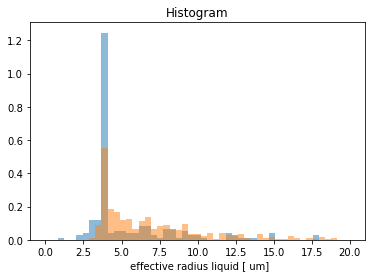

In [433]:
_ds['re_liq_test'].where(_ds['liq_cloud_time']>0).where(_ds['liq_cloud_time']<10000).isel(lon=0, lat=1, lev=-20).plot.hist(bins=bins, alpha=0.5, density=True)
_ds['re_liq_test'].where(_ds['liq_cloud_time']>10000).isel(lon=0, lat=1, lev=-20).plot.hist(bins=bins, alpha=0.5, density=True)
#_ds['re_liq'].where(_ds['liq_cloud_time']>2000).isel(lon=0, lat=1, lev=-20).plot.hist(bins=bins, alpha=0.5, color='r')
#_ds['re_liq'].where(_ds['liq_cloud_time']>0).isel(lon=0, lat=1, lev=-20).plot.hist(bins=bins, alpha=0.5)

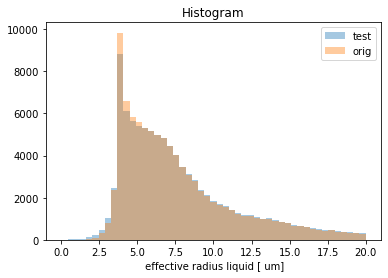

In [370]:
_ds['re_liq_test'].where(_ds['cl_frac_where_cltime_pos']>0).isel(lev=-22).plot(bins=bins, alpha=0.4, label='test');
_ds['re_liq'].where(_ds['cl_frac_where_cltime_pos']>0).isel(lev=-22).plot(bins=bins, alpha=0.4, label='orig');
plt.legend()

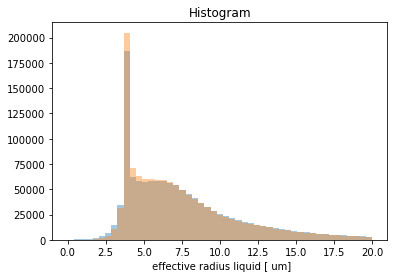

In [348]:
(_ds['re_liq_test']).where(_ds['cl_frac_where_cltime_pos']>0).plot(bins=bins, alpha=0.4);
_ds['re_liq'].where(_ds['cl_frac_where_cltime_pos']>0).plot(bins=bins, alpha=0.4);

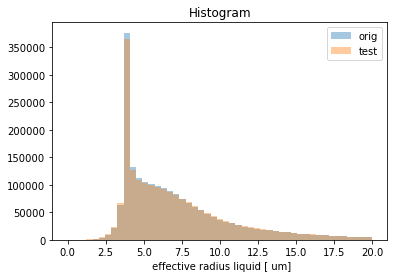

In [341]:
_ds['re_liq'].where(_ds['cl_time_liq_norm']>0.5).where(_ds['cl_time_liq_norm']>.3).plot(bins=bins, alpha=0.4,label='orig');
_ds['re_liq_test'].where(_ds['cl_time_liq_norm']>0.5).where(_ds['cl_time_liq_norm']>.3).plot(bins=bins, alpha=0.4, label='test');
plt.legend()

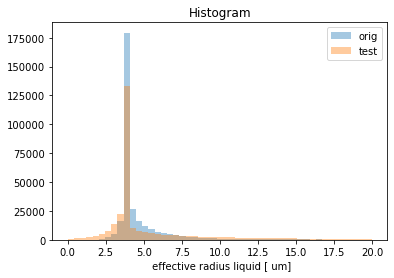

In [338]:
_ds['re_liq'].where(_ds['cl_time_liq_norm']>0).where(_ds['cl_time_liq_norm']<.3).plot(bins=bins, alpha=0.4,label='orig');
_ds['re_liq_test'].where(_ds['cl_time_liq_norm']>0).where(_ds['cl_time_liq_norm']<.3).plot(bins=bins, alpha=0.4, label='test');
plt.legend()

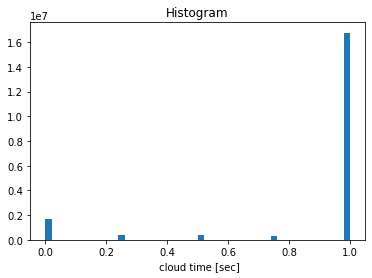

In [324]:
(1- _ds['cl_time_liq_norm']).plot(bins=50);

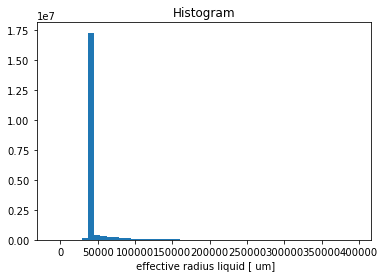

In [306]:
_ds['re_liqxcltime'].plot(bins=50);

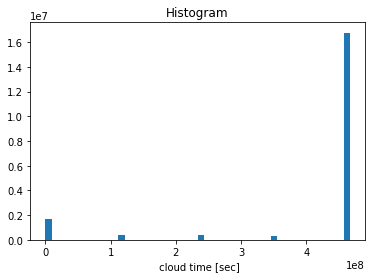

In [307]:
_ds['4_liqx(tott-cltime)'].plot(bins=50);

(array([21016402.,        0.,   842928.,        0.,        0.,  1087821.,
               0.,  1480279.,        0.,  4681650.]),
 array([-2.1083413e-12,  1.0800000e+03,  2.1600000e+03,  3.2400000e+03,
         4.3200000e+03,  5.4000000e+03,  6.4800000e+03,  7.5600000e+03,
         8.6400000e+03,  9.7200000e+03,  1.0800000e+04], dtype=float32),
 <BarContainer object of 10 artists>)

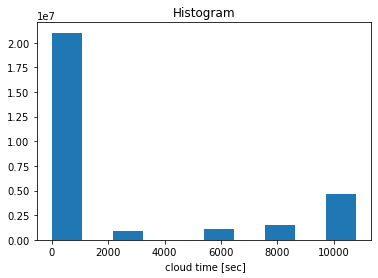

In [44]:
_ds['liq_cloud_time'].plot()

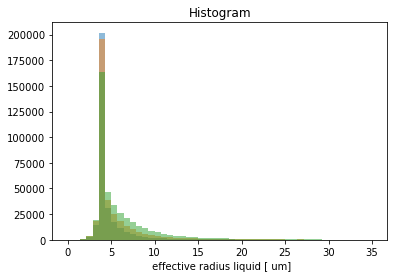

In [203]:
_ds['re_liq_incld5'].where(_ds['liq_cloud_time']>2000).where(_ds['liq_cloud_time']<5000).plot(bins=bins, alpha=.5);

_ds['re_liq_incld5'].where(_ds['liq_cloud_time']>5000).where(_ds['liq_cloud_time']<7000).plot(bins=bins, alpha=.5);
_ds['re_liq_incld5'].where(_ds['liq_cloud_time']>7000).where(_ds['liq_cloud_time']<9000).plot(bins=bins, alpha=.5);

In [288]:
bins = np.linspace(0,20)

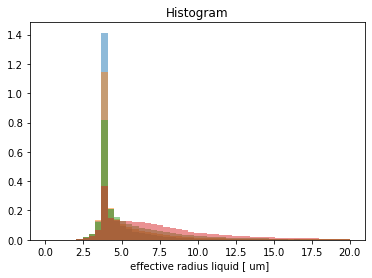

In [289]:
_ds['re_liq'].where(_ds['liq_cloud_time']>2000).where(_ds['liq_cloud_time']<5000).plot(bins=bins, alpha=.5, density=True);

_ds['re_liq'].where(_ds['liq_cloud_time']>5000).where(_ds['liq_cloud_time']<7000).plot(bins=bins, alpha=.5, density=True);
_ds['re_liq'].where(_ds['liq_cloud_time']>7000).where(_ds['liq_cloud_time']<9000).plot(bins=bins, alpha=.5, density=True);
_ds['re_liq'].where(_ds['liq_cloud_time']>10000).where(_ds['liq_cloud_time']<11000).plot(bins=bins, alpha=.5, density=True);

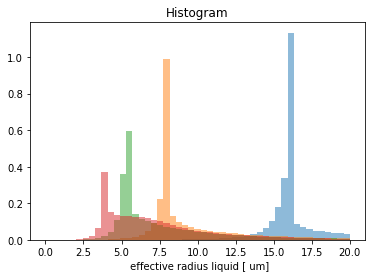

In [290]:
_ds['re_liq_incld'].where(_ds['liq_cloud_time']>2000).where(_ds['liq_cloud_time']<5000).plot(bins=bins, alpha=.5, density=True);

_ds['re_liq_incld'].where(_ds['liq_cloud_time']>5000).where(_ds['liq_cloud_time']<7000).plot(bins=bins, alpha=.5, density=True);
_ds['re_liq_incld'].where(_ds['liq_cloud_time']>7000).where(_ds['liq_cloud_time']<9000).plot(bins=bins, alpha=.5, density=True);
_ds['re_liq_incld'].where(_ds['liq_cloud_time']>10000).where(_ds['liq_cloud_time']<11000).plot(bins=bins, alpha=.5, density=True);

In [51]:
_ds2 = _ds.sel(time=slice('2012-01','2012-04'))

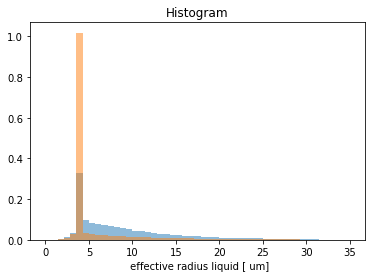

In [67]:
_ds2['re_liq'].where(_ds2['cl_frac_where_cltime_pos']>.1).plot(bins=bins, alpha=.5, density=True);

_ds2['re_liq'].plot(bins=bins, alpha=.5, density=True);

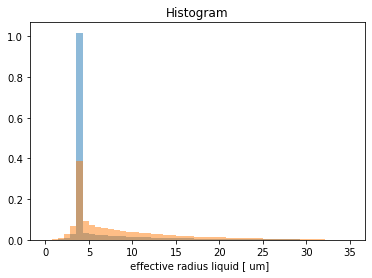

In [74]:
_ds2['re_liq'].where(_ds2['ttc']>.1).plot(bins=bins, alpha=.5, density=True);

_ds2['re_liq'].where(_ds2['re_liq']!=4.).plot(bins=bins, alpha=.5, density=True);

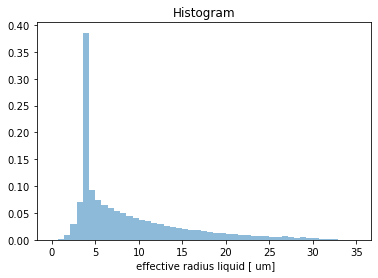

In [75]:
_ds2['re_liq'].where(_ds2['re_liq']!=4.).plot(bins=bins, alpha=.5, density=True);

In [78]:
bins = np.linspace(3,5)

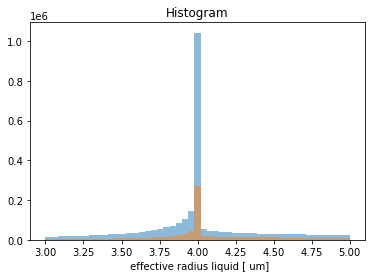

In [87]:
_ds2['re_liq'].where(_ds2['re_liq']!=4.).plot(bins=bins, alpha=.5);
_ds2['re_liq'].where(_ds2['re_liq']!=4.).where(_ds2['cl_frac_where_cltime_pos']>.01).plot(bins=bins,alpha=.5);

In [73]:
(_ds2['re_liq']==4.).sum()/

<xarray.DataArray 're_liq' ()>
array(12078323)
Attributes:
    table:      126
    long_name:   effective radius liquid
    units:       um

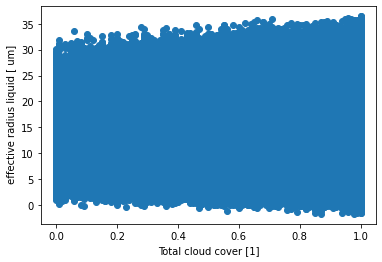

In [55]:
_ds2.plot.scatter(x='ttc', y='re_liq')

In [46]:
_dsa = _ds.where(_ds['re_liq']<4.2)

KeyboardInterrupt: 

In [ ]:
_dsa['re_liq'].isel(lat=0,lon=0).plot()

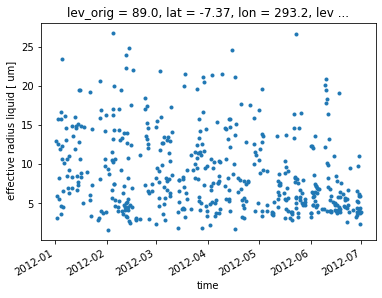

In [56]:
_ds['re_liq'].where(_ds['liq_cloud_time']>10000).isel(lat=0,lon=0, lev=88).plot(linewidth=0, marker='.');


In [87]:
bins = np.linspace(3.8,4.2)

(array([ 1.22306506,  1.25699117,  1.28804219,  1.31564309,  1.34468155,
         1.36883234,  1.39442067,  1.42633422,  1.49361142,  1.52293738,
         1.60085244,  1.65289164,  1.70234326,  1.76387028,  1.83977276,
         1.89353702,  1.98697758,  2.09335607,  2.22043523,  2.35498964,
         2.56803412,  2.67613766,  2.9949856 ,  3.63181896, 50.46336543,
         1.343244  ,  1.28746717,  1.26245385,  1.24606582,  1.24922842,
         1.20035182,  1.17763857,  1.15722541,  1.15578786,  1.14371246,
         1.15377529,  1.1327871 ,  1.09426084,  1.08592307,  1.09799847,
         1.11783661,  1.09023571,  1.09512337,  1.06004722,  1.06637243,
         1.05975971,  1.0623473 ,  1.05372201,  1.0287087 ]),
 array([3.8       , 3.80816327, 3.81632653, 3.8244898 , 3.83265306,
        3.84081633, 3.84897959, 3.85714286, 3.86530612, 3.87346939,
        3.88163265, 3.88979592, 3.89795918, 3.90612245, 3.91428571,
        3.92244898, 3.93061224, 3.93877551, 3.94693878, 3.95510204,
        3

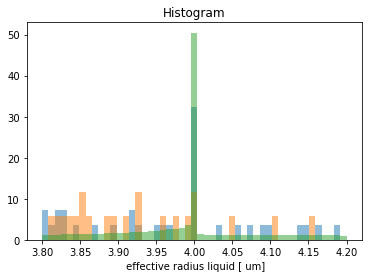

In [88]:
_ds['re_liq'].where(_ds['liq_cloud_time']>10000).isel(lat=0,lon=0, lev=88).plot.hist(bins=bins, alpha=0.5, density=True)#(linewidth=0, marker='.');
_ds['re_liq'].where(_ds['liq_cloud_time']>10000).isel(lat=0,lon=0, lev=80).plot.hist(bins=bins, alpha=0.5, density=True)#(linewidth=0, marker='.');
_ds['re_liq'].where(_ds['liq_cloud_time']>10000).plot.hist(bins=bins, alpha=0.5, density=True)#(linewidth=0, marker='.');


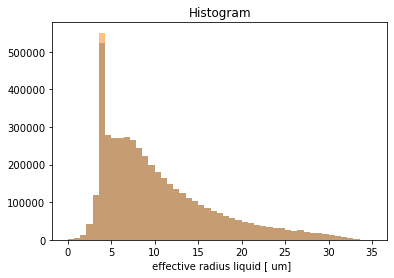

In [72]:
_ds['re_liq'].where(_ds['re_liq']!=4).where(_ds['liq_cloud_time']>10000).plot(bins=bins, alpha=.5);
_ds['re_liq'].where(_ds['liq_cloud_time']>10000).plot(bins=bins, alpha=.5);
                    
                    
                    

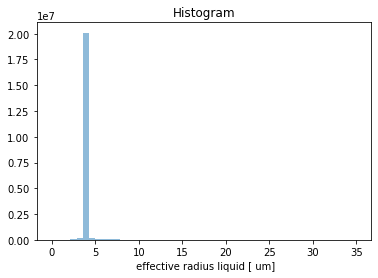

In [66]:
_ds['re_liq'].where(_ds['liq_cloud_time']<2000).plot(bins=bins, alpha=.5);


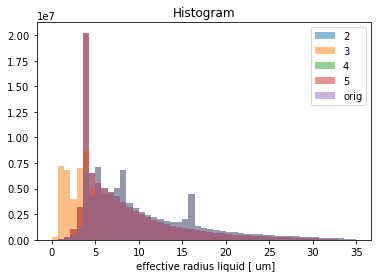

In [174]:
bins = np.linspace(0,35)

ds['re_liq_incld2'].plot(bins=bins, alpha=0.5, label='2')
ds['re_liq_incld3'].plot(bins=bins, alpha=0.5, label='3')
ds['re_liq_incld4'].plot(bins=bins, alpha=0.5, label='4')
ds['re_liq_incld5'].plot(bins=bins, alpha=0.5, label='5')
#ds['re_liq'].plot(bins=bins, alpha=.5, label='');
# ds['re_liq_incld'].plot(bins=bins, alpha=.5, label='orig');
plt.legend()

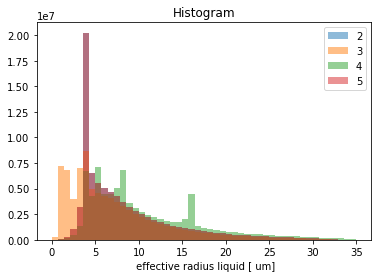

In [176]:
bins = np.linspace(0,35)

ds['re_liq_incld2'].plot(bins=bins, alpha=0.5, label='2')
ds['re_liq_incld3'].plot(bins=bins, alpha=0.5, label='3')
ds['re_liq_incld4'].plot(bins=bins, alpha=0.5, label='4')
ds['re_liq_incld5'].plot(bins=bins, alpha=0.5, label='5')
#ds['re_liq'].plot(bins=bins, alpha=.5, label='');
# ds['re_liq_incld'].plot(bins=bins, alpha=.5, label='orig');
plt.legend()

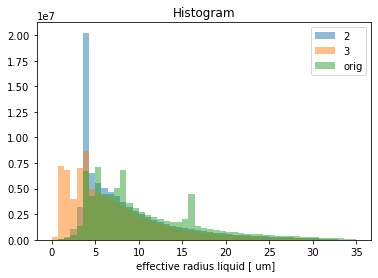

In [170]:
bins = np.linspace(0,35)

ds['re_liq_incld2'].plot(bins=bins, alpha=0.5, label='2')
ds['re_liq_incld3'].plot(bins=bins, alpha=0.5, label='3')
ds['re_liq_incld4'].plot(bins=bins, alpha=0.5, label='4')
#ds['re_liq'].plot(bins=bins, alpha=.5, label='');
ds['re_liq_incld'].plot(bins=bins, alpha=.5, label='orig');
plt.legend()

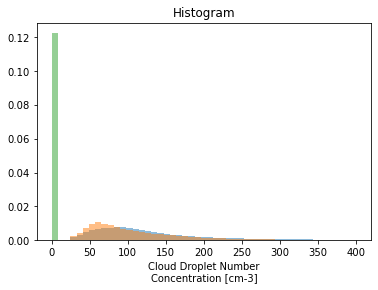

In [155]:
bins = np.linspace(0,400)
ds['cdnc_incld_cltop'].plot(bins=bins, alpha=.5, density=True);

ds['cdnc_incld'].plot(bins=bins, alpha=.5, density= True);
ds['cdnc'].plot(bins=bins, alpha=.5, density= True);

(array([6.1402377e+07, 1.9579252e+07, 2.3927030e+06, 6.0181800e+05,
        2.4559600e+05, 1.1879800e+05, 6.5185000e+04, 3.4928000e+04,
        1.4308000e+04, 9.9400000e+02]),
 array([9.89363980e-05, 1.45346880e+01, 2.90692768e+01, 4.36038666e+01,
        5.81384583e+01, 7.26730423e+01, 8.72076340e+01, 1.01742226e+02,
        1.16276817e+02, 1.30811401e+02, 1.45345993e+02], dtype=float32),
 <BarContainer object of 10 artists>)

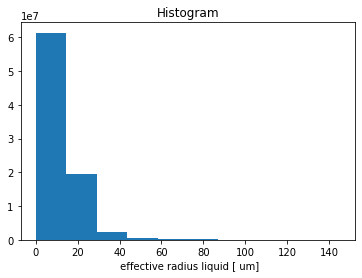

In [146]:
ds['re_liq_incld'].plot()

In [ ]:
    for key in dic_ds:
        _ds = dic_ds[key]
        ds_l = _ds.isel(lev= model_lev_i)
        dic_ds[key] = ds_l

  

      
    ds_t = dic_ds['IFS_T']
    
    ds = dic_ds['IFS']
    ds = ds.sortby('lat')
    ds = ds.sortby('lon')

    ds_t['lev'] = ds['lev']
    ds_t = ds_t.sortby('lat')
    ds_t = ds_t.sortby('lon')
    ds_t['temp'].plot()
    plt.show()

    drop_list = ['U','V','temp']
    ds = xr.merge([ds.drop_vars(drop_list).drop_dims(['plev']),ds_t[['temp']]])
    ds['temp'].plot()
    plt.show()
    

    # ds =fix_units_ec_earth(ds)
    # ds = calculate_incld_values_warmclouds(ds)
    # ds = extract_cloud_top(ds)

    delayed_obj = ds.to_netcdf(fn_intermediate_ec_earth, compute=False)
    with ProgressBar():
        delayed_obj.compute()
    

In [27]:
fn_intermediate_ec_earth#.exists()

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0_intermediate.nc')

In [28]:
ds_ifs = xr.open_dataset(fn_intermediate_ec_earth, decode_times=False)


In [29]:
ds_ifs

<xarray.Dataset>
Dimensions:                   (nhyi: 92, nhym: 91, lat: 10, lon: 22, time: 20198)
Coordinates:
    lev_orig                  float64 ...
  * lat                       (lat) float64 -7.37 -6.67 -5.96 ... -1.75 -1.05
  * lon                       (lon) float64 293.2 293.9 294.6 ... 307.3 308.0
  * time                      (time) float64 0.0 3.0 6.0 ... 6.136e+04 6.136e+04
    lev                       float64 ...
Dimensions without coordinates: nhyi, nhym
Data variables: (12/40)
    hyai                      (nhyi) float64 ...
    hyam                      (nhym) float64 ...
    hybi                      (nhyi) float64 ...
    hybm                      (nhym) float64 ...
    tcw                       (time, lat, lon) float32 ...
    tcwv                      (time, lat, lon) float32 ...
    ...                        ...
    cumsum                    (time, lat, lon) float32 ...
    argmax                    (time, lat, lon) int64 ...
    cdnc_incld_cltop          (time, lat, lon) float32 ...
    re_liq_incld_cltop        (time, lat, lon) float32 ...
    cc_cltop                  (time, lat, lon) float32 ...
    temp                      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Dec 20 16:59:11 2022: ncrcat /proj/bolinc/users/x_sarbl...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.2 (http://mpimet.mpg.de/...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [30]:
ds_ifs['ttc'].attrs['units'] =1

In [31]:
import numpy as np

## Fix wrong units:

In [32]:
for v in ds_ifs.data_vars:
    if 'units' in ds_ifs[v].attrs:
        print(v, ds_ifs[v].attrs['units'])
        if ds_ifs[v].attrs['units'] is np.nan:
            print('******')
        if ds_ifs[v].attrs['units']==1:
            ds_ifs[v].attrs['units'] ='1'
            print(f'{v} unit is 1')

hyai Pa
hyam Pa
hybi 1
hybm 1
tcw g m-2
tcwv g m-2
ttc 1
ttc unit is 1
surf_net_srad J m-2
surf_net_lrad J m-2
toa_net_srad J m-2
toa_net_lrad J m-2
cdnc cm-3
toa_net_srad_clear J m-2
re_liq  um
surf_net_srad_clear J m-2
sur_net_lrad_clear J m-2
liq_cloud_time sec
cc 1
toa_net_srad_clearclean J m-2
toa_net_srad_clean J m-2
surf_net_srad_clearclean J m-2
surf_net_srad_clean J m-2
toa_net_lrad_clearclean J m-2
toa_net_lrad_clean J m-2
surf_net_lrad_clearclean J m-2
surf_net_lrad_clean J m-2
tclw g m-2
tciw g m-2
re_liq_incld  um
cdnc_incld cm-3
cc_liq sec
cc_all 1
liq_frac_cwp g m-2
cl_frac_where_cltime_pos 1
cumsum 1
argmax 1
cdnc_incld_cltop cm-3
re_liq_incld_cltop  um
cc_cltop 1
temp K


In [33]:
ds_ifs = xr.decode_cf(ds_ifs)
ds_ifs['time'].attrs['timezone'] = 'utc'

In [34]:
import numpy as np

(array([483622.,  92545.,  51724.,  33488.,  32372.,  29850.,  29372.,
         35092.,  29878.,  95146.]),
 array([0.0078125 , 0.10703125, 0.20625   , 0.30546874, 0.4046875 ,
        0.50390625, 0.603125  , 0.70234376, 0.8015625 , 0.9007813 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

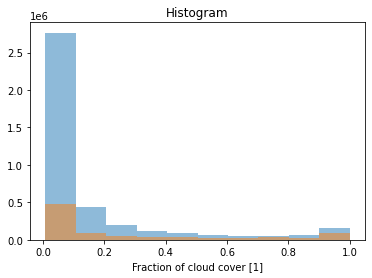

In [35]:
ds_ifs['cc_cltop'].plot(alpha=.5)

ds_ifs['cc_all'].plot(alpha=.5)

## Mask values where cloud fraction is less than 10 percent

In [36]:
ds_ifs = ds_ifs.where(ds_ifs['cc_cltop']>.1)

In [37]:
ds_ifs['tcw']

<xarray.DataArray 'tcw' (time: 20198, lat: 10, lon: 22)>
array([[[      nan,       nan, 59550.44 , ..., 50872.707, 51806.3  ,
               nan],
        [      nan, 58333.645, 58761.38 , ...,       nan,       nan,
               nan],
        [56962.55 , 56982.082, 55730.13 , ...,       nan,       nan,
               nan],
        ...,
        [51263.332, 51011.38 ,       nan, ...,       nan,       nan,
         50757.473],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan, 57271.01 , ..., 49968.277,       nan,
               nan],
        [      nan, 56466.324, 56940.934, ..., 51075.7  ,       nan,
         51819.84 ],
        [56747.574, 55413.59 , 55528.824, ...,       nan,       nan,
               nan],
...
        [49874.773, 49849.383,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan, 48054.164,
         50423.305],
        [55563.93 , 55981.9  ,       nan, ..., 48376.43 ,       nan,
         50071.742],
        [      nan, 55153.773, 53894.008, ..., 50360.805,       nan,
         48259.242],
        ...,
        [      nan,       nan, 55261.195, ...,       nan,       nan,
               nan],
        [      nan,       nan, 53245.57 , ...,       nan, 53895.96 ,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
    lev_orig  float64 90.0
  * lat       (lat) float64 -7.37 -6.67 -5.96 -5.26 ... -3.16 -2.46 -1.75 -1.05
  * lon       (lon) float64 293.2 293.9 294.6 295.3 ... 305.9 306.6 307.3 308.0
  * time      (time) datetime64[ns] 2012-01-01T03:00:00 ... 2019-01-01
    lev       float64 996.0
Attributes:
    table:      128
    long_name:  Total column water
    units:      g m-2

## Shift timezone

In [38]:
from datetime import timedelta
with ProgressBar():
    ds_ifs.load()
    
    
if ds_ifs['time'].attrs['timezone']=='utc':
    ds_ifs['time'] = ds_ifs['time'].to_pandas().index - timedelta(hours=4)
    ds_ifs['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    #dic_ds[k] = _ds

shifted time by -4


### Use station data computed before:

In [39]:
df_comb_station = dic_df_station[model_name_ec_earth][case_name_ec_earth]

In [40]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station=ds_comb_station.assign_coords(station=['ATTO'])

(array([1.51000e+02, 1.04122e+05, 5.65446e+05, 2.52688e+05, 1.13434e+05,
        7.47400e+04, 7.19950e+04, 7.97960e+04, 2.77730e+04, 6.69000e+02]),
 array([290.4117 , 293.0742 , 295.73666, 298.39914, 301.0616 , 303.72406,
        306.38654, 309.049  , 311.7115 , 314.37396, 317.03644],
       dtype=float32),
 <BarContainer object of 10 artists>)

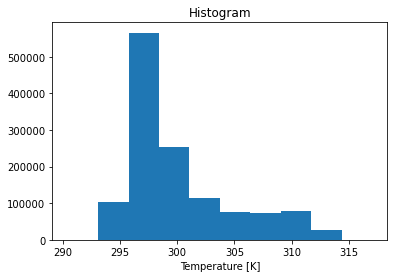

In [41]:
ds_ifs['temp'].plot()

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(
/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/core/indexes.py:224: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = index.get_loc(


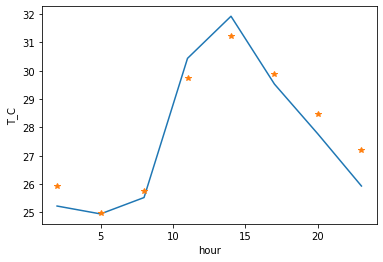

In [42]:
ds_ifs['hour'] = ds_ifs['time.hour']
(ds_ifs['temp']-273.15).groupby(ds_ifs['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot(marker='*')

In [43]:
varl_station_ec_earth = [
 'CCN0.20',
 'CCN1.00',
 'M_BCACS',
 'M_BCAII',
 'M_BCAIS',
 'M_BCCOS',
 'M_DUACI',
 'M_DUACS',
 'M_DUCOI',
 'M_DUCOS',
 'M_POMACS',
 'M_POMAII',
 'M_POMAIS',
 'M_POMCOS',
 'M_SO4ACS',
 'M_SO4COS',
 'M_SO4NUS',
 'M_SOAACS',
 'M_SOAAII',
 'M_SOAAIS',
 'M_SOACOS',
 'M_SOANUS',
 'M_SSACS',
 'M_SSCOS',
    'OA',
    'SOA',
 'N_ACI',
 'N_ACS',
 'N_AII',
 'N_AIS',
 'N_COI',
 'N_COS',
 'N_NUS',
 'RDRY_ACS',
 'RDRY_AIS',
 'RDRY_COS',
 'RDRY_NUS',
 'RWET_ACI',
 'RWET_ACS',
 'RWET_AII',
 'RWET_AIS',
 'RWET_COI',
 'RWET_COS',
 'RWET_NUS',
 'emiisop',
 'emiterp',
 'T',
 'DDRY_NUS',
 'DDRY_AIS',
 'DDRY_ACS',
 'DDRY_COS',
 'DWET_AII',
 'DWET_ACI',
 'DWET_COI',
 'N50',
 'N70',
 'N100',
 'N150',
 'N200',
 'N500',
 'N50-500',
 'N70-500',
 'N100-500',
 'N150-500',
 'N200-500',
 'OA',
 'POM',
 'SOA',
 'SOA2',
 'T_C',
    
]

In [44]:

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_station_ec_earth)))

In [45]:
ds_smll = ds_ifs[['temp']]

In [46]:
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel, rn_dic_ec_earth_cloud

In [47]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds= False)

M_POMACS
M_SSCOS
M_DUCOS
M_POMAII
M_SO4COS
N150
M_BCACS
M_DUACS
M_SOAAIS
M_SSACS
N100-500
N_COS
OA
M_BCAIS
N500
CCN1.00
N_COI
M_SO4NUS
M_SOACOS
DDRY_COS
T
N_NUS
RWET_AII
N_ACS
N100
POM
RWET_ACI
N70
M_POMCOS
RDRY_COS
RWET_COI
SOA
RDRY_AIS
DDRY_ACS
N70-500
M_POMAIS
T_C
RDRY_ACS
M_DUCOI
M_SO4ACS
N50-500
emiterp
N_AIS
N150-500
DWET_AII
N_AII
emiisop
RWET_COS
DDRY_NUS
M_SOAACS
RWET_AIS
CCN0.20
RWET_NUS
DDRY_AIS
M_BCCOS
M_DUACI
M_SOANUS
M_SOAAII
RDRY_NUS
M_BCAII
RWET_ACS
N200
N_ACI
N50
DWET_COI
N200-500
SOA2
DWET_ACI


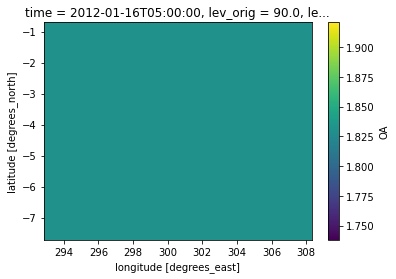

In [48]:
ds_smll['OA'].isel(time=122).plot()

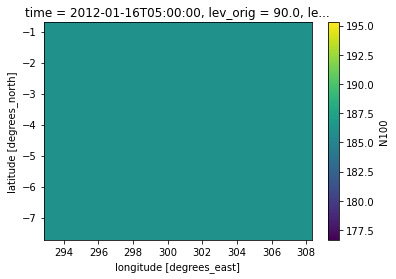

In [49]:
ds_smll['N100'].isel(time=122).plot()

## Replace all values by station values

In [50]:
for v in varl_tmp:
    ds_ifs[v] = ds_smll[v]

### Mask values where ice water path larger than 20 percent

(array([199702.,  93231.,  99067., 101604.,  91697.,  85866.,  84293.,
         86825., 109924., 338176.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

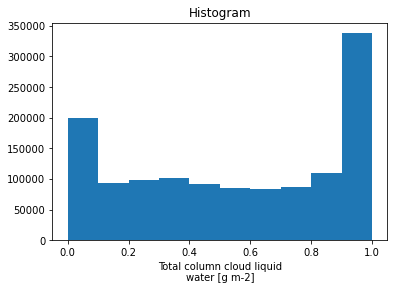

In [51]:
ds_ifs['liq_frac_cwp'].plot()

In [53]:
ds_ifs = ds_ifs.where(ds_ifs['liq_frac_cwp']>.8)

(array([3.63399e+05, 7.99750e+04, 3.38500e+03, 6.41000e+02, 2.02000e+02,
        6.00000e+01, 2.70000e+01, 1.10000e+01, 9.00000e+00, 2.00000e+00]),
 array([  0.58366233,  13.402384  ,  26.221106  ,  39.039825  ,
         51.858547  ,  64.67727   ,  77.49599   ,  90.31471   ,
        103.13343   , 115.952156  , 128.77087   ], dtype=float32),
 <BarContainer object of 10 artists>)

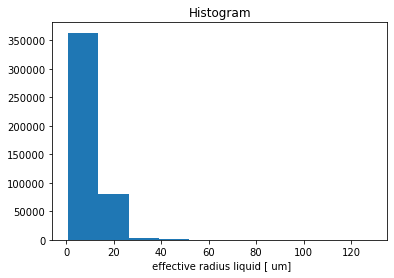

In [66]:
ds_ifs['re_liq_incld_cltop'].plot()

## Calculate in-cloud liquid water path:

In [67]:
#ds_ifs.rename({'CWP':'CWP_tot'})
ds_ifs['cwp_incld'] = ds_ifs['tclw']/ds_ifs['ttc']

## Save for different seasons: 


In [68]:
dic_ds = dict()
dic_ds[case_name_ec_earth] = ds_ifs

In [70]:
#calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ec_earth_cloud)

In [72]:
ds = dic_ds[key]

(array([ 6019., 33584., 34046., 48107., 40192., 41114., 54539., 28257.,
        20699., 16201., 13457., 10771.,  9179.,  8019.,  7450.,  7880.,
        12149., 30309.,  4188.,  3313.,  2567.,  2019.,  1675.,  1370.,
         1161.,   983.,   839.,   724.,   665.,   582.,   500.,   459.,
          421.,   326.,   302.,   242.,   194.,   197.,   152.,   176.,
          146.,   108.,   110.,   109.,   102.,    95.,    83.,    58.,
           70.]),
 array([ 3.        ,  3.75510204,  4.51020408,  5.26530612,  6.02040816,
         6.7755102 ,  7.53061224,  8.28571429,  9.04081633,  9.79591837,
        10.55102041, 11.30612245, 12.06122449, 12.81632653, 13.57142857,
        14.32653061, 15.08163265, 15.83673469, 16.59183673, 17.34693878,
        18.10204082, 18.85714286, 19.6122449 , 20.36734694, 21.12244898,
        21.87755102, 22.63265306, 23.3877551 , 24.14285714, 24.89795918,
        25.65306122, 26.40816327, 27.16326531, 27.91836735, 28.67346939,
        29.42857143, 30.18367347, 30.93

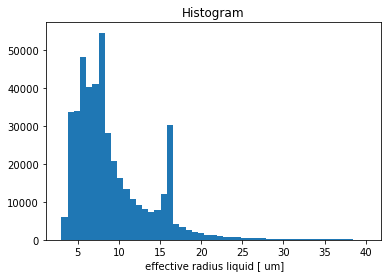

In [75]:
ds['r_eff'].plot(bins = np.linspace(3,40))

In [76]:
ds['CWP_unweigth'] = ds['tclw']

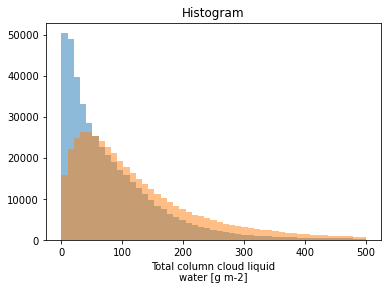

In [77]:
ds['CWP_unweigth'].plot(bins=np.linspace(0,500), alpha=.5);
ds['CWP'].plot(bins=np.linspace(0,500), alpha=.5);

## Check 

(array([3.63399e+05, 7.99750e+04, 3.38500e+03, 6.41000e+02, 2.02000e+02,
        6.00000e+01, 2.70000e+01, 1.10000e+01, 9.00000e+00, 2.00000e+00]),
 array([  0.58366233,  13.402384  ,  26.221106  ,  39.039825  ,
         51.858547  ,  64.67727   ,  77.49599   ,  90.31471   ,
        103.13343   , 115.952156  , 128.77087   ], dtype=float32),
 <BarContainer object of 10 artists>)

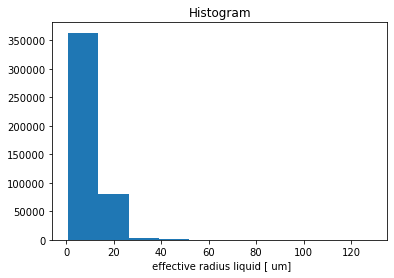

In [79]:
ds['r_eff'].plot()

Text(0.5, 1.0, 'CWP divided by cloud fraction')

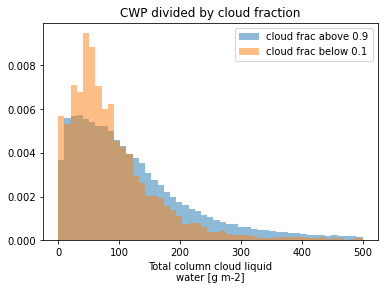

In [80]:
ds['CWP'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP'].where(ds['ttc']<.1).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP divided by cloud fraction')

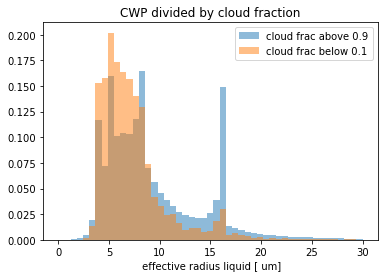

In [94]:
ds['r_eff'].where(ds['ttc']>.9).plot(bins=np.linspace(0,30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc']<.1).plot(bins=np.linspace(0,30), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

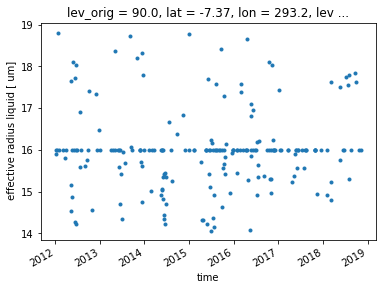

In [109]:
ds['r_eff'].where(ds['r_eff']>14).where(ds['r_eff']<19).isel(lat=0, lon = 0).plot(linewidth=0, marker='.')

In [104]:
ds['r_eff'].where((ds['r_eff']==16)).count()/ds['r_eff'].where(ds['r_eff']>0).count()

<xarray.DataArray 'r_eff' ()>
array(0.01501862)
Coordinates:
    lev_orig  float64 90.0
    lev       float64 996.0
Attributes:
    table:      126
    long_name:   effective radius liquid
    units:       um

Text(0.5, 1.0, 'CWP divided by cloud fraction')

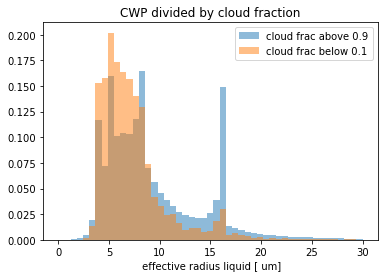

In [94]:
ds['r_eff'].where(ds['ttc']>.9).plot(bins=np.linspace(0,30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc']<.1).plot(bins=np.linspace(0,30), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

Text(0.5, 1.0, 'CWP not divided ')

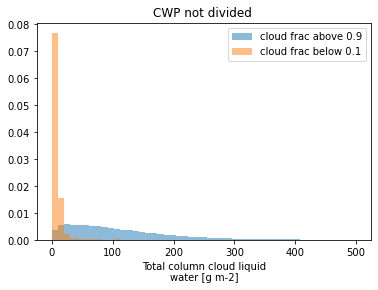

In [81]:
ds['CWP_unweigth'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP_unweigth'].where(ds['ttc']<.1).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP not divided ')

In [85]:
for seas in calc_seasons:
    _fn_csv = fn_final_ec_earth_csv_stem.parent / (fn_final_ec_earth_csv_stem.name + seas+'.csv')
    print(_fn_csv)
    if True:#not _fn_csv.exists():
        #for key in dic_ds.keys():
    
        dic_df = get_dic_df_mod(dic_ds, 
                                select_hours_clouds=True, 
                                summer_months=season2month[seas],
                                mask_cloud_values =True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                #kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds = dict(min_reff=r_eff_lim,
                                                         min_cwp =cld_water_path_above, 
                                                         tau_bounds = tau_lims
                                                        ),
                                
                               
                               )

        df_mod = dic_df[case_name_ec_earth]
        #with ProgressBar():
        df_mod = df_mod.dropna()    
        df_mod.to_csv(_fn_csv)

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0ALL_year.csv
{'min_reff': 1, 'min_cwp': 50, 'tau_bounds': [5, 50]}
Masking with 50<CWP!
Masking with r_eff>1!


KeyboardInterrupt: 

In [226]:
f

Index(['tcwv', 'tclw', 'cl_frac_where_cltime_pos', 'tcw', 're_liq_incld',
       'cc_all', 'cc_cltop', 're_liq', 'liq_frac_cwp', 'CWP',
       ...
       'RWET_COS', 'N70', 'N200', 'M_BCAII', 'M_DUCOI', 'DWET_AII', 'RDRY_COS',
       'RWET_ACI', 'DWET_ACI', 'year'],
      dtype='object', length=106)

In [1]:
df = pd.read_csv(_fn_csv, index_col=[0,1,2])

NameError: name 'pd' is not defined

<AxesSubplot:ylabel='Frequency'>

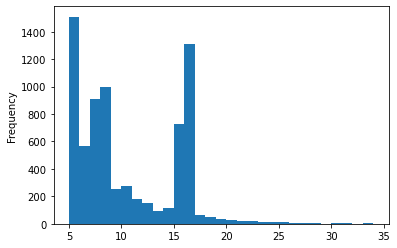

In [91]:
df['r_eff'].plot.hist(bins=np.arange(5,35))

In [ ]:
from datetime import timedelta